In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import elasticsearch
from elasticsearch import helpers
import time
import datetime

# PROCESS REACTOME (SECOND-LEVEL) PATHWAY FILES

## IMPORT ALL NEEDED FILES

In [54]:
# Get all gene_set_pathway files 
dir_path = os.getcwd()
tmp = os.listdir(dir_path + "/gene_set_data")
input_files = [ dir_path + "/gene_set_data/" + file_name for file_name in tmp ]

The following step processes each one of the input files and gives them an appropriate formatting.<br>
In addition, the information is stored in a single dataframe.

In [55]:
# Read a file which stores all the second-level pathways and their corresponding genes at once
file = "/home/ricard/Documents/reactome/seconLevel_pathways.tsv"
toplevel = pd.DataFrame()

print("Processing files...")
df = pd.read_csv(file, sep="\n", header=None)
df = df[0].str.split("\t", expand=True).transpose()
df.columns = df.iloc[0]
df.drop([0,1], inplace=True)
df.reset_index(drop=True, inplace=True)
df = df.loc[:,~df.columns.duplicated()]
toplevel = pd.concat([df, toplevel], axis=1)
print("Finished!")

Processing files...
Finished!


In [56]:
toplevel.head()

,Macroautophagy,Chaperone Mediated Autophagy,Late endosomal microautophagy,Meiosis,"Cell Cycle, Mitotic",Cell Cycle Checkpoints,Chromosome Maintenance,Nephrin family interactions,Signal regulatory protein family interactions,Cell junction organization,...,ABC-family proteins mediated transport,SLC-mediated transmembrane transport,Aquaporin-mediated transport,Miscellaneous transport and binding events,Mitochondrial calcium ion transport,Intracellular oxygen transport,Iron uptake and transport,Ion channel transport,Membrane Trafficking,Binding and Uptake of Ligands by Scavenger Receptors
0,AMBRA1,ARL13B,ARL13B,ACD,AAAS,AHCTF1,ACD,ACTN1,CD47,ACTN1,...,ABCA10,AHCYL2,ADCY1,ADD1,AFG3L2,CYGB,ABCG2,ANO1,AAK1,ALB
1,ARL13B,CETN1,CETN1,ATM,ABL1,ANAPC1,ANKRD28,ACTN2,FYB,AFDN,...,ABCA12,APOD,ADCY2,ADD2,AKAP1,MB,ACO1,ANO10,ACBD3,AMBP
2,ATG10,CFTR,CFTR,ATR,ACTR1A,ANAPC10,APITD1,ACTN3,GRB2,ANG,...,ABCA2,ARL2,ADCY3,ADD3,C2orf47,NGB,ALAD,ANO2,ACTR10,APOA1
3,ATG101,EEF1A1,CHMP2A,BLM,AHCTF1,ANAPC11,ATRX,ACTN4,PTK2,ARHGEF6,...,ABCA3,ARL2BP,ADCY4,ANKH,LETM1,None,ATP6AP1,ANO3,ACTR1A,APOB
4,ATG12,GFAP,CHMP2B,BRCA1,AJUBA,ANAPC15,BLM,CASK,PTK2B,CADM1,...,ABCA4,AVP,ADCY5,AZGP1,MCU,None,ATP6V0A1,ANO4,ACTR2,APOE


The following code defines a function which will perform the connection with the ES database to retrieve all the queried information about the presence or absence of the genes.

In [57]:
# Function that looks up each gene in ES
def query_geneSymbol(gene_symbol, index_name="dgnplus_gene_v19"):
    resp = helpers.scan(
        elasticsearch.Elasticsearch([{'host': '127.0.0.1', 'port': 3307}], timeout=30), # when run from home
        index=index_name,
        scroll='8m',
        size=1000,
        query={
            "_source": ["symbol_keyword", "geneID"], # fields we want to retrieve
            "query": {
                "term": {"symbol_keyword": {"value": gene_symbol}} # PMID to search for
            }
        }
    )
    if resp:
        return resp
    else:
        return None

Here we calculate the number of completely unique gene symbols in our initial Dataframe created from the Reactome data.

In [58]:
reactome_genes = set()
for col in toplevel:
    mask = toplevel[col].notnull()
    y = set(toplevel[col][mask])
    reactome_genes.update(y)
print(len(reactome_genes))

11397


Here we do the hard work, this code may take several minutes to run because in fact is looking for all the genes from the Reactome files in ES. In the case a gene is found, it adds +1 to a counter and when it finishes with that pathway it adds a row to a new Dataframe which will store all second-level pathways from <i>Homo sapiens</i> in Reactome and all their corresponding gene counts (genes found in ES).

This code chunk may take around 30 minutes to complete.

In [59]:
starttime = time.time()
genes_in_dgnplus = pd.DataFrame(columns=["name", "count_dgnplus"])

print("Querying ES for all genes coming from Reactome...")
for colname in toplevel:
    gene_set = set()
    gene_set.update(list(toplevel[colname][~toplevel[colname].isnull()]))
    
    counter = 0
    gene_set = list(gene_set)
    for gene in gene_set:
        for response in query_geneSymbol(gene):
            if "_source" in response.keys() and "symbol_keyword" in response["_source"].keys():
                counter += 1
    new_row = pd.Series({"name":colname, "count_dgnplus":counter})
    genes_in_dgnplus = pd.concat([genes_in_dgnplus, new_row.to_frame().T], ignore_index=True)

endtime = time.time()
print("ELAPSED TIME (hh:mm:ss): {}".format(datetime.timedelta(seconds=(endtime-starttime))))

Querying ES for all genes coming from Reactome...
ELAPSED TIME (hh:mm:ss): 0:27:11.352689


In [60]:
# Create small df from reactome data with pathway names and gene counts
counts_reactome = toplevel.count()
counts_reactome = pd.DataFrame(counts_reactome, columns=['count_reactome']).reset_index().rename({0:'name'}, axis=1)
counts_reactome

,name,count_reactome
0,Macroautophagy,117
1,Chaperone Mediated Autophagy,21
2,Late endosomal microautophagy,33
3,Meiosis,88
4,"Cell Cycle, Mitotic",530
...,...,...
161,Intracellular oxygen transport,3
162,Iron uptake and transport,59
163,Ion channel transport,179
164,Membrane Trafficking,612


## BARPLOTS OF GENE COUNTS FOR EACH REACTOME PATHWAY

Then, we create a grouped barplot in which for each Reactome pathway we plot both the gene counts as reported in Reactome and the ones retrieved from DGN+.

As it can be seen the values are almost always close to each other for each pathway, but never equal, meaning that not all genes from Reactome are stored in DGN+.

In [61]:
#Merge reactome and dgnplus dfs
merged_df = counts_reactome
merged_df["count_dgnplus"] = genes_in_dgnplus["count_dgnplus"] # Merge both dfs
merged_df = merged_df.sort_values(by="count_reactome").reset_index(drop=True) # Sort values by one of the counts column, in this case I chose the Reactome one because it's always larger
merged_df.head()

,name,count_reactome,count_dgnplus
0,Intracellular oxygen transport,3,3
1,Pyrophosphate hydrolysis,3,3
2,Diseases of cellular response to stress,3,3
3,NR1D1 (REV-ERBA) represses gene expression,4,4
4,Invadopodia formation,4,4


We will split the <b>merged_df</b> in two, so in this way we can see better the results. Otherwise there were to many pathways on the X-axis.

In [62]:
split = int(len(merged_df)/2 + 0.5) if isinstance(len(merged_df)/2, float) else int(len(merged_df)/2)

merged_df_first = merged_df.iloc[:split, :]

merged_df_second = merged_df.iloc[split:, :]

We define a function to create the barplot with our desired format.

In [90]:
def make_barplot(df, bar_width = 0.4):
    #Create canvas
    plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True
    plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False
    fig, ax = plt.subplots(figsize = (20,10))

    # Set position of bar on X axis
    barWidth = bar_width
    r1 = np.arange(len(df["count_reactome"]))
    r2 = [x + barWidth for x in r1]

    # Create barplots
    plt.bar(r1, df["count_reactome"], width=barWidth, edgecolor='white', 
            label='Reactome gene counts', color=(0.2, 0.4, 0.8, 0.6)) # Counts from genes in Reactome
    plt.bar(r2, df["count_dgnplus"], width=barWidth, edgecolor='white', 
            label='DGN+ gene counts', color=(0.9, 0.5, 0.2, 0.9))

    #Mod axes, ticks, and titles
    plt.xlabel('Pathway name', fontweight='bold', size=16)
    plt.ylabel('Gene count', fontweight='bold', size=16)
    plt.xticks([r + barWidth/2 for r in range(len(df["count_reactome"]))], 
               list(df["name"]), rotation=45, horizontalalignment='right')
    plt.xlim(-0.5,len(df))
    plt.title("Barplot with pathway's gene counts", size = 20)

    # Show legend and plot
    plt.legend(loc=2, prop={'size': 15})
    plt.show()

### BARPLOT OF THE LOWER HALF OF THE MERGED DATAFRAME

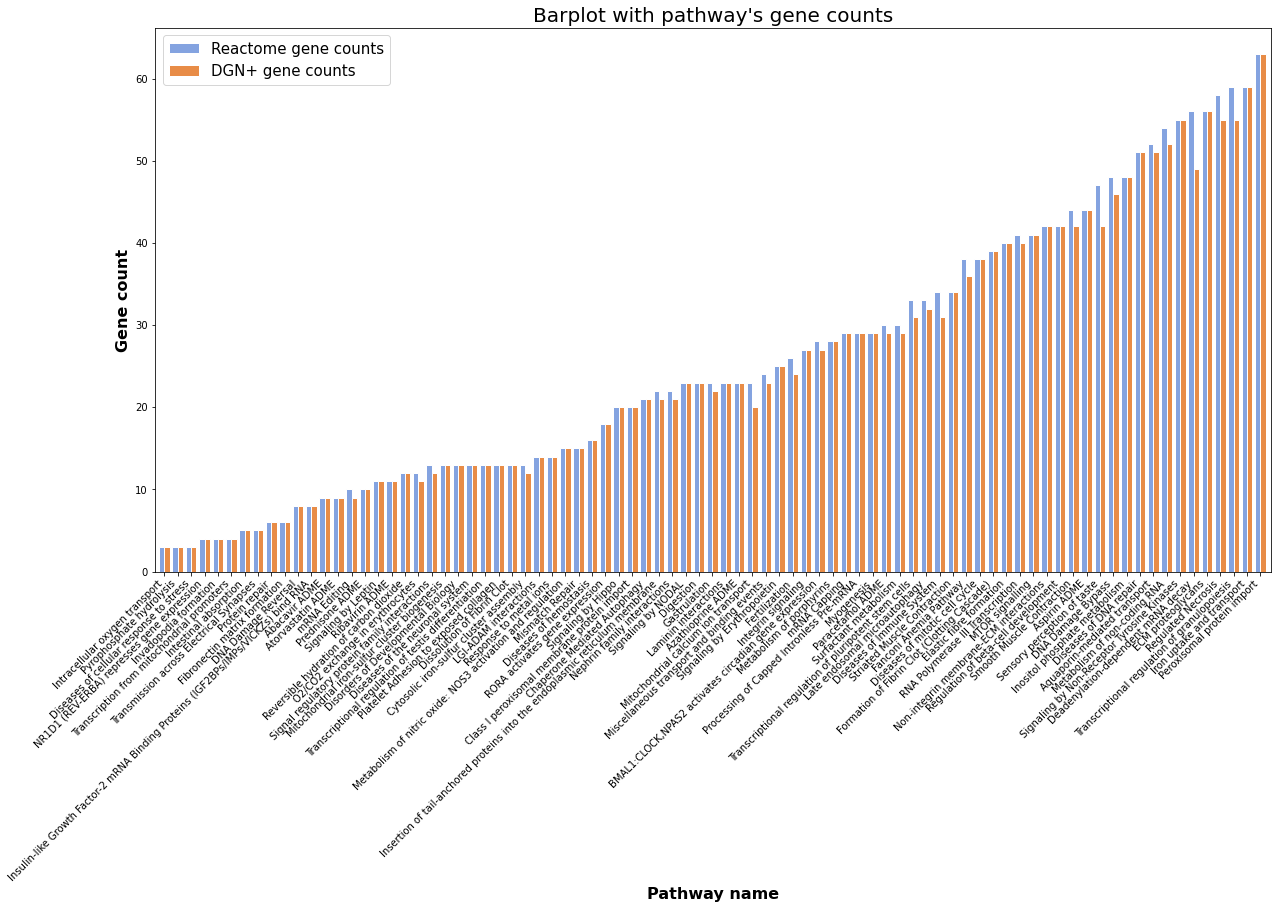

In [91]:
make_barplot(merged_df_first)

### BARPLOT OF THE UPPER HALF OF THE MERGED DATAFRAME

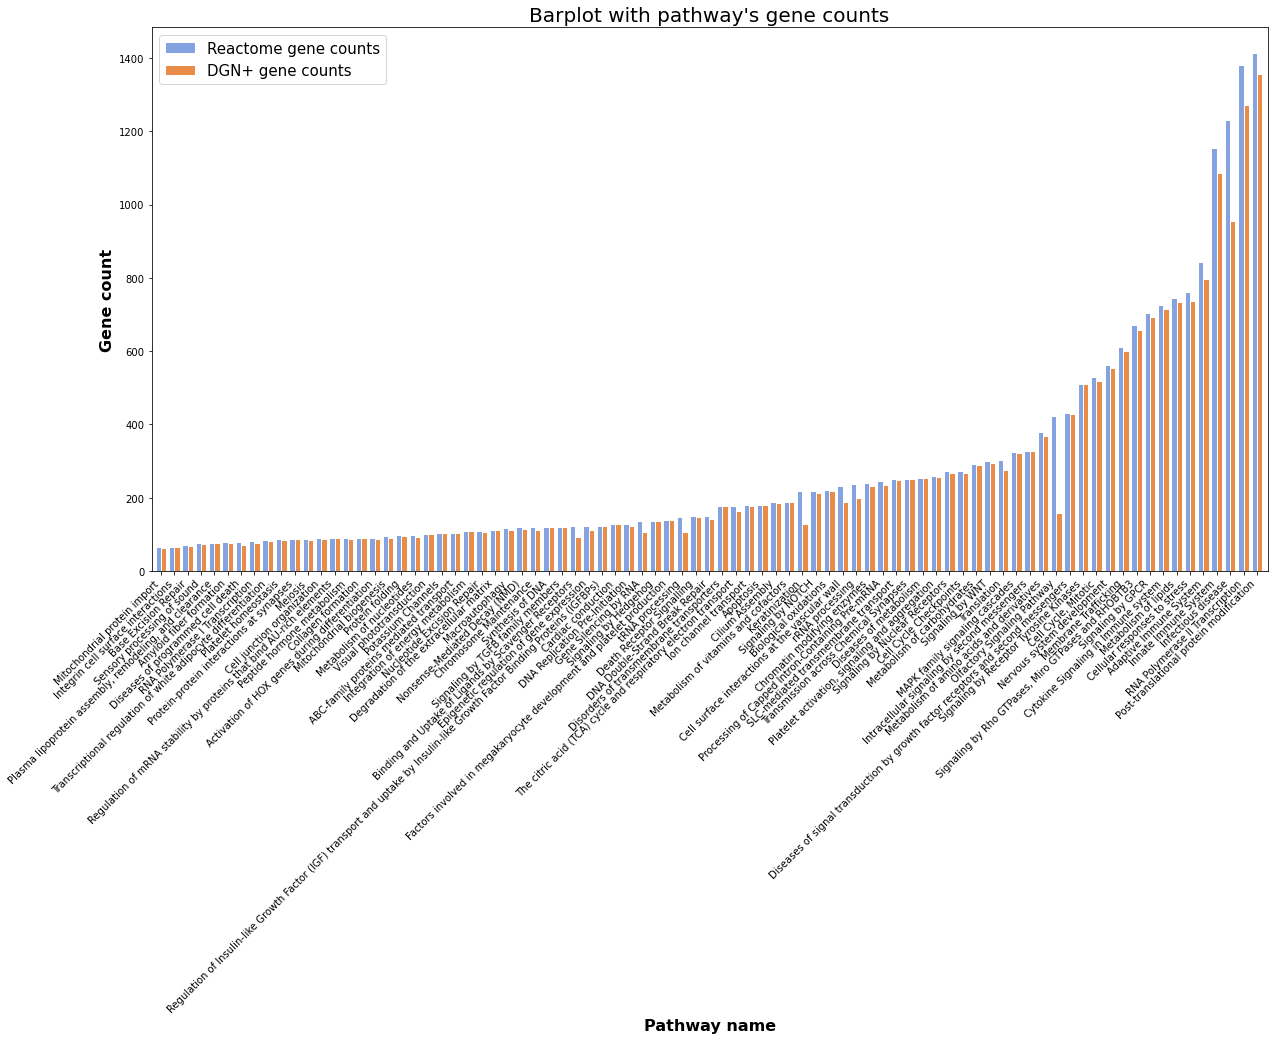

In [92]:
make_barplot(merged_df_second)

## HEATMAP PLOTTING THE JACCARD INDEX FOR ALL PATHWAY-PATHWAY PAIRS

After that, we want to know the proportion of genes shared between each Reactome second-level pathway using their data.

To do so, we compute the Jaccard index for each possible pair of second-level pathways.

In [66]:
toplevel.shape

(1413, 166)

In [67]:
# Create a numpy array which stores the percentages of shared genes for each possible pathway-pathway pair
final_array = np.zeros(shape = (1, len(toplevel.columns)))

for idx, c_colname in enumerate(toplevel):
    tmp_array = np.zeros(shape=final_array.shape[1])
    i_gene_set = set(toplevel[c_colname])
    length_i_genset = len(i_gene_set)
    
    for idx2, other_colname in enumerate(toplevel):
        o_gene_set = set(toplevel[other_colname])
        intersect = len(i_gene_set.intersection(o_gene_set)) - 1 # number of genes present in the intersection between sets !!None is count as a value!!
        union = len(i_gene_set.union(o_gene_set)) - 1 # number of genes present in the union between sets
        if union == 0:
            print(">>> WARNING: Union between {} and {} pathways is 0".format(c_colname, other_colname))
            print("Cannot compute Jaccard index because would rise a math error!!!")
            print("Skipping this pair of pathways\n")
            continue
            
        tmp_array[idx2] = intersect/union # Calculate Jaccard index between sets
        
    final_array = np.vstack((final_array, tmp_array)) # Add new row of Jaccard indexes to the final array
    
final_array = final_array[1:,:] # remove first row because it was just a full 0 row to initialize the array

In [68]:
# Reformat the labels so they fit in the following heatmap and create a df with the percentages info
labels = [sentence[:25] + "-\n" + sentence[25:] if len(sentence[25:])>4 else sentence[:25] 
          for sentence in list(toplevel.columns)]

# final_df = pd.DataFrame(final_array, index = labels, columns = labels) # labeled heatmap
final_df = pd.DataFrame(final_array) # no labels in heatmap

Finally, we plot the computed results into a heatmap.

Text(0.5, 1.0, "Heatmap of computed Jaccard index\nbetween pathways' genes")

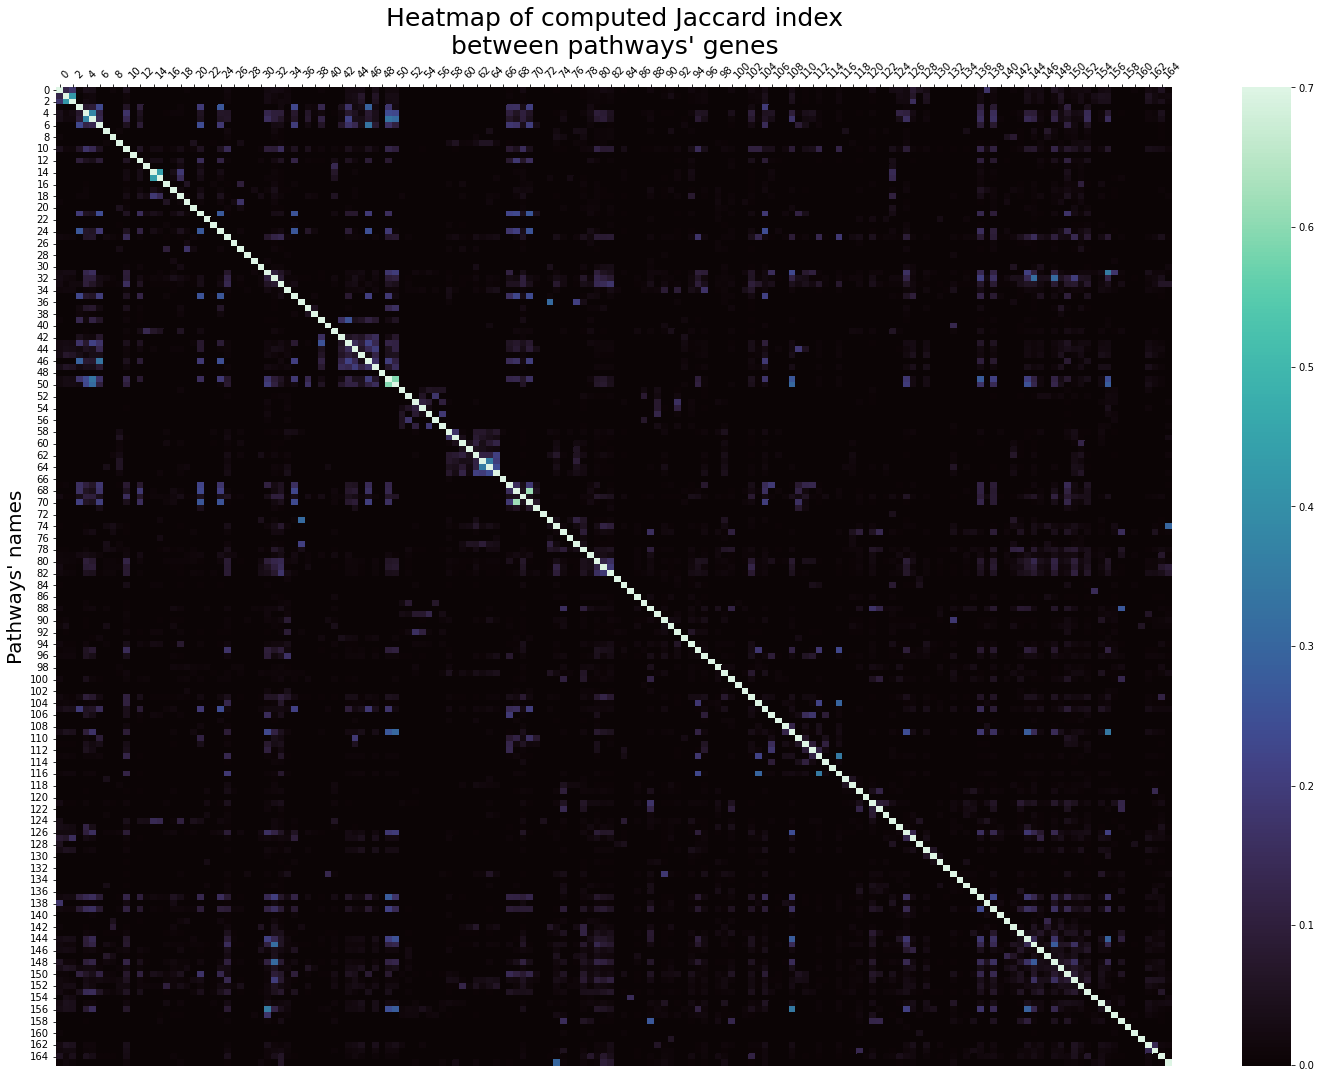

In [69]:
# Create heatmap object
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

fig, ax = plt.subplots(figsize = (25,18))
# heatmap = sns.heatmap(final_df, annot = True, annot_kws={'size': 13}, fmt=".2f", vmin=0, vmax=0.25, cmap="mako")
heatmap = sns.heatmap(final_df, vmax=0.70, cmap="mako")
heatmap.set_xticklabels(heatmap.get_xticklabels())
plt.xticks(rotation=45, horizontalalignment='left')
heatmap.set_ylabel("Pathways' names", size=20)
heatmap.set_title("Heatmap of computed Jaccard index\nbetween pathways' genes", size = 25)

## ANNOTATED DGN+ GENES NOT PRESENT IN REACTOME

In [70]:
# Function that looks up each gene in ES
def query_geneSymbol_list(index_name="dgnplus_gene_v19"):
    resp = helpers.scan(
        elasticsearch.Elasticsearch([{'host': '127.0.0.1', 'port': 3307}], timeout=30), # when run from home
        index=index_name,
        scroll='8m',
        size=10000,
        query={
            "query": {
                "match_all": {} 
            },
            "docvalue_fields": ["symbol_keyword"],
            "_source": False
        }
    )
    if resp:
        return resp
    else:
        return None

Here we retrieve all genes from DGN+. First we do it in a list type object and then in a set.

As it can be noted, there are a couple of genes which are duplicated, which are the ones printed later.

Also, there is one entry which did not have any gene symbol associated.

In [71]:
dgnplus_genes = []
dgnplus_genes_set = set()

for idx, resp in enumerate(query_geneSymbol_list()): # generator function
    if resp["fields"]["symbol_keyword"] == '' or resp["fields"]["symbol_keyword"] == [''] or resp["fields"]["symbol_keyword"] is None:
        print("This gene entry has not any gene symbol associated: {}".format(resp))
        continue
    dgnplus_genes.append(resp["fields"]["symbol_keyword"][0])
    dgnplus_genes_set.update(resp["fields"]["symbol_keyword"])

print("If we group the results in a list, there are {} genes in DGN+".format(len(dgnplus_genes)))
print("If we group the results in a set, there are {} genes in DGN+".format(len(dgnplus_genes_set)))

This gene entry has not any gene symbol associated: {'_index': 'dgnplus_gene_v19', '_type': '_doc', '_id': 'H_jiJIEBfTBKnLAph0ti', '_score': None, 'fields': {'symbol_keyword': ['']}, 'sort': [138990]}
If we group the results in a list, there are 24248 genes in DGN+
If we group the results in a set, there are 24246 genes in DGN+


In [72]:
x = pd.Series(dgnplus_genes)
x[x.duplicated()]

16904    RNR2
18325    RNR1
dtype: object

In [73]:
intersect_dgnplus_reactome = dgnplus_genes_set.intersection(reactome_genes)
print("There are {} genes shared between DGN+ and Reactome".format(len(intersect_dgnplus_reactome)))
print("There are {} genes in Reactome not stored in DGN+".format(len(reactome_genes.difference(dgnplus_genes_set))))
print("There are {} genes in DGN+ not stored in Reactome".format(len(dgnplus_genes_set.difference(reactome_genes))))
print("DGN+ has {:.2f}% coverage over Reactome".format(len(intersect_dgnplus_reactome)/len(dgnplus_genes_set)*100))

There are 10335 genes shared between DGN+ and Reactome
There are 1062 genes in Reactome not stored in DGN+
There are 13911 genes in DGN+ not stored in Reactome
DGN+ has 42.63% coverage over Reactome


## DISEASE PATHWAY COVERAGE (TOP-LEVEL)

In [74]:
string = "Diseases of Immune System,Disorders of transmembrane transporters,Diseases of signal transduction by growth factor receptors and second messengers,Infectious disease,Diseases of metabolism,Diseases of programmed cell death,Diseases of hemostasis,Diseases of mitotic cell cycle,Diseases of cellular response to stress,Diseases of DNA repair,Diseases of the neuronal system,Disorders of Developmental Biology"
disease_second_level_ids = string.split(",")
disease_second_level_ids

['Diseases of Immune System',
 'Disorders of transmembrane transporters',
 'Diseases of signal transduction by growth factor receptors and second messengers',
 'Infectious disease',
 'Diseases of metabolism',
 'Diseases of programmed cell death',
 'Diseases of hemostasis',
 'Diseases of mitotic cell cycle',
 'Diseases of cellular response to stress',
 'Diseases of DNA repair',
 'Diseases of the neuronal system',
 'Disorders of Developmental Biology']

Here we want to know how many genes from the original Reactoma data and which are related to Disease pathways are also present in DGN+. We would expect a very high percentage or even the totality of them, as DGN+ particularly focused on disease data.

Then, we start subsetting all the disease-related pathways from Reactome into a smaller Dataframe.

In [75]:
disease_genes_reactome = pd.DataFrame()

for id in disease_second_level_ids:
    disease_genes_reactome[id] = toplevel[id]
disease_genes_reactome = disease_genes_reactome.mask(disease_genes_reactome.eq('None')).dropna(how='all')
disease_genes_reactome

,Diseases of Immune System,Disorders of transmembrane transporters,Diseases of signal transduction by growth factor receptors and second messengers,Infectious disease,Diseases of metabolism,Diseases of programmed cell death,Diseases of hemostasis,Diseases of mitotic cell cycle,Diseases of cellular response to stress,Diseases of DNA repair,Diseases of the neuronal system,Disorders of Developmental Biology
0,BTK,AAAS,ADAM10,18S rRNA,ABCA3,3a,F10,ANAPC1,CDK4,ATM,ABCA4,BDNF
1,CD14,ABCA1,ADAM17,1a,ABCD4,APP,F11,ANAPC10,CDK6,ATR,LRAT,CALM1
2,CD36,ABCA12,AGGF1,28S rRNA,ACACA,BCL2L11,F12,ANAPC11,CDKN2A,ATRIP,NAPEPLD,CAMK4
3,CHUK,ABCA3,AGK,3a,ACAN,C1QBP,F2,ANAPC15,None,BARD1,OPN1LW,GPS2
4,FGA,ABCB11,AGTRAP,3b,ACY1,CAPN1,F8,ANAPC16,None,BLM,OPN1MW,HDAC1
...,...,...,...,...,...,...,...,...,...,...,...,...
1227,None,None,None,trxA,None,None,None,None,None,None,None,None
1228,None,None,None,trxB,None,None,None,None,None,None,None,None
1229,None,None,None,vif,None,None,None,None,None,None,None,None
1230,None,None,None,vpr,None,None,None,None,None,None,None,None


After that, we look up each one of these disease-related pathway genes in DGN+.

This process may take around 2-3 minutes.

In [76]:
starttime = time.time()
# disease_genes_in_dgnplus = pd.DataFrame()
in_disgenet_symbols = {}

print("Querying ES for disease-related genes from Reactome...")
for colname in disease_genes_reactome:
    gene_set = set()
    gene_set.update(list(disease_genes_reactome[colname][~disease_genes_reactome[colname].isnull()]))
    
    in_disgenet_symbols[colname] = []
    
    gene_set = list(gene_set)
    for gene in gene_set:
        for response in query_geneSymbol(gene):
            if "_source" in response.keys() and "symbol_keyword" in response["_source"].keys() and response["_source"]["symbol_keyword"] is not None:
                in_disgenet_symbols[colname].append(gene)

endtime = time.time()
print("ELAPSED TIME (hh:mm:ss): {}".format(datetime.timedelta(seconds=(endtime-starttime))))

Querying ES for disease-related genes from Reactome...
ELAPSED TIME (hh:mm:ss): 0:02:16.309983


In [77]:
react = {'Diseases of Immune System': [],
  'Disorders of transmembrane transporters': [],
  'Diseases of signal transduction by growth factor receptors and second messengers': [],
  'Infectious disease': [],
  'Diseases of metabolism': [],
  'Diseases of programmed cell death': [],
  'Diseases of hemostasis': [],
  'Diseases of mitotic cell cycle': [],
  'Diseases of cellular response to stress': [],
  'Diseases of DNA repair': [],
  'Diseases of the neuronal system': [],
  'Disorders of Developmental Biology': []}

for diction in disease_genes_reactome.to_dict('records'):
    for k, v in diction.items():
        if v is not None:
            react[k].append(v) 
        else: continue

Now we create a Dataframe which will only store the genes present in Reactome but not in DGN+ for all disease-related pathways. 

Theoretically we would expect a very low difference for disease-pathways.

In [78]:
diff_df = pd.DataFrame()

for in_dgn, in_react in zip(in_disgenet_symbols.items(), react.items()):
    tmp_df = pd.DataFrame()
    gene_diff = set(in_react[1]).difference(set(in_dgn[1]))
    tmp_df[in_react[0]] = pd.Series(list(gene_diff))
    diff_df = pd.concat([diff_df, tmp_df], axis=1)

/home/ricard/anaconda3/envs/disgenet/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [79]:
diff_df

,Diseases of Immune System,Disorders of transmembrane transporters,Diseases of signal transduction by growth factor receptors and second messengers,Infectious disease,Diseases of metabolism,Diseases of programmed cell death,Diseases of hemostasis,Diseases of mitotic cell cycle,Diseases of cellular response to stress,Diseases of DNA repair,Diseases of the neuronal system,Disorders of Developmental Biology
0,porB,NaN,PHB,UL41A,NaN,H2BC14,NaN,NaN,NaN,NaN,NaN,NaN
1,fliC,NaN,NaN,SCP,NaN,SPI-2,NaN,NaN,NaN,NaN,NaN,NaN
2,mip,NaN,NaN,IGKV1-33,NaN,3a,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,IGLV2-18,NaN,H2BC1,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,RL1,NaN,RIR1,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
273,NaN,NaN,NaN,H2AC21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
274,NaN,NaN,NaN,UL130,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
275,NaN,NaN,NaN,cpnT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
276,NaN,NaN,NaN,UL87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Then, suign the aforementioned Dataframe, we create another one only with the difference counts for each pathway, and later on we will build a barplot with these counts.

In [80]:
diff_counts = pd.DataFrame(diff_df.count(), columns=['difference_count']).reset_index().rename({'index':'pathway_name'}, axis=1).sort_values(by='difference_count')
diff_counts

,pathway_name,difference_count
1,Disorders of transmembrane transporters,0
4,Diseases of metabolism,0
6,Diseases of hemostasis,0
7,Diseases of mitotic cell cycle,0
8,Diseases of cellular response to stress,0
9,Diseases of DNA repair,0
10,Diseases of the neuronal system,0
11,Disorders of Developmental Biology,0
2,Diseases of signal transduction by growth fact...,1
0,Diseases of Immune System,3


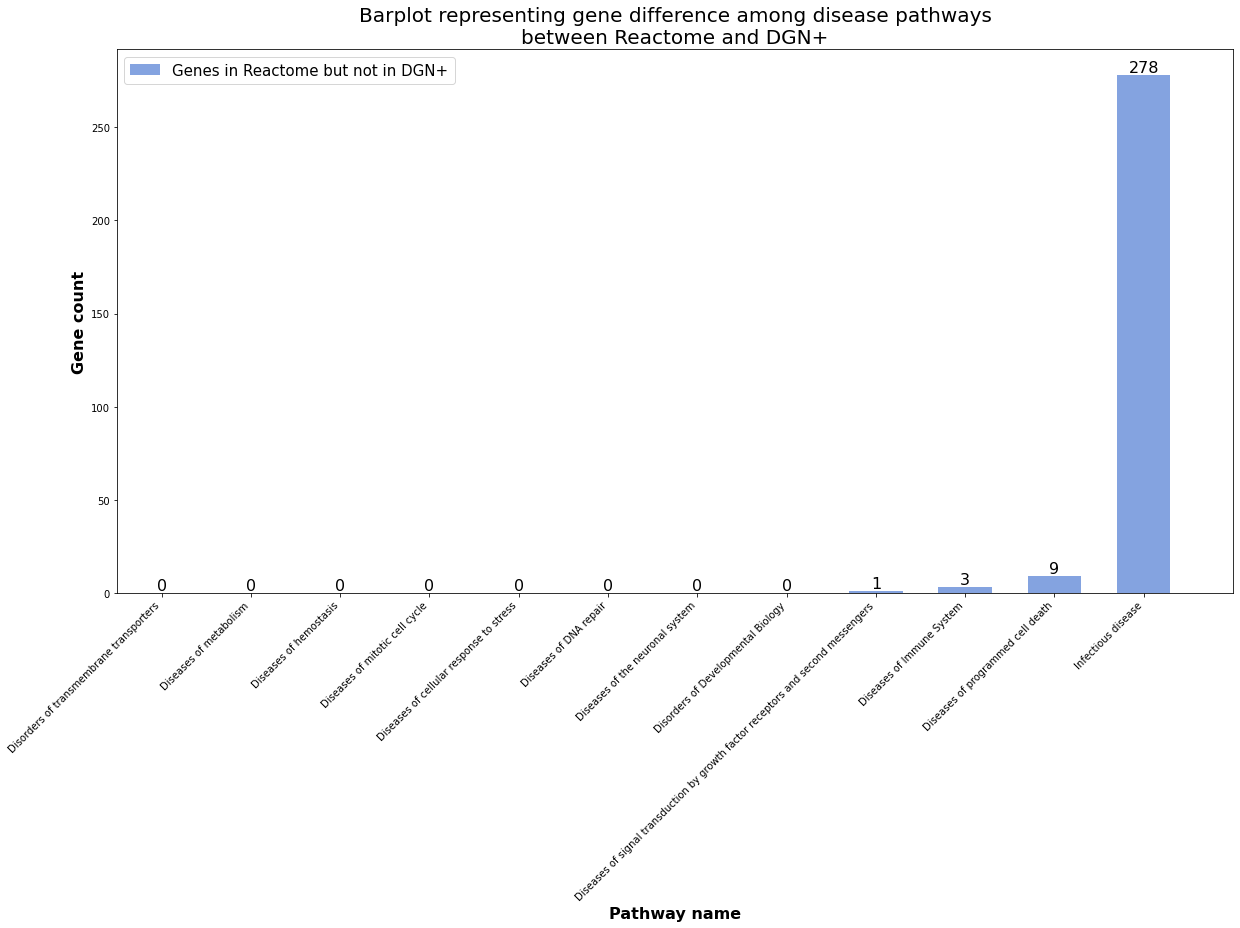

In [81]:
#Create canvas
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False
fig, ax = plt.subplots(figsize = (20,10))

# Set position of bar on X axis
barWidth = 0.6
r1 = np.arange(len(diff_counts["difference_count"]))

# Create barplot
barplot = plt.bar(r1, diff_counts["difference_count"], width=barWidth, 
        label='Genes in Reactome but not in DGN+', color=(0.2, 0.4, 0.8, 0.6)) # Counts from genes in Reactome

#Mod axes, ticks, and titles
plt.xlabel('Pathway name', fontweight='bold', size=16)
plt.ylabel('Gene count', fontweight='bold', size=16)
plt.xticks([r for r in range(len(diff_counts["difference_count"]))], 
           list(diff_counts["pathway_name"]), rotation=45, horizontalalignment='right')
plt.xlim(-0.5,len(diff_counts))
plt.title("Barplot representing gene difference among disease pathways\nbetween Reactome and DGN+", size = 20)

def autolabel(barplot):
    for bar in barplot:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height, '%d' % int(height), ha='center', va='bottom', size=16)

autolabel(barplot)

# Show legend and plot
plt.legend(loc=2, prop={'size': 15})
plt.show()